Import Libraries.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.fftpack import dct, idct

Read the input image and convert it to grayscale.

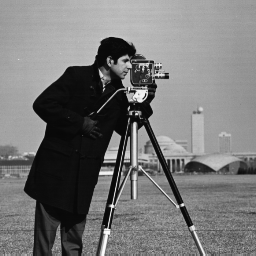

In [ ]:
x=cv2.imread('/content/cameraman.tif',cv2.IMREAD_GRAYSCALE)
cv2_imshow(x)
m, n = x.shape



Define the DCT(Discrete Cosine Transform) functions.

In [ ]:
def dct2d(x):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')



Define the IDCT(Inverse Discrete Cosine Transform) functions.

In [ ]:
def idct2d(x):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')





Transform the image to the DCT domain.
The image divided into 8 of block size.

In [ ]:
block_size=8
dct_coefficients = np.zeros((m, n), dtype=np.float32)
for i in range(0,m,block_size):
  for j in range(0,n,block_size):
    block = x[i:i+block_size,j:j+block_size]
    dct_coefficients[i:i+block_size, j:j+block_size]=dct2d(block)



Blocks of images(8*8).

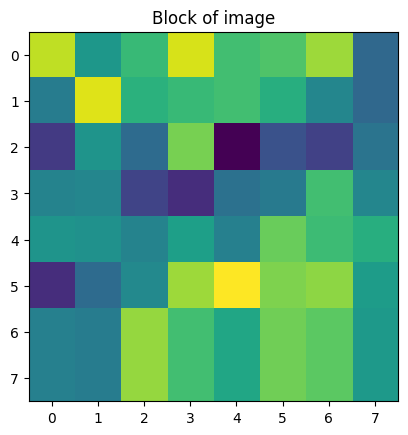

In [ ]:
plt.imshow(block)
plt.title('Block of image')
plt.show()

DCT Coefficient image.

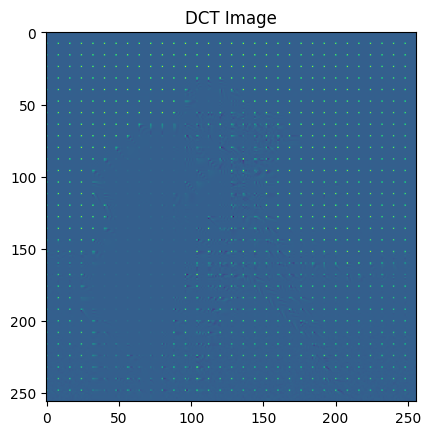

In [ ]:
plt.imshow(dct_coefficients)
plt.title('DCT Image')
plt.show()

Compressed sensing: compress each DCT block to a lower dimension.

In [ ]:
np.random.seed(42)
measurement_matrix = np.random.randn(block_size**2, block_size**2)



Compressed Blocks with Block size and flatten the blocks of image.

In [ ]:
compressed_blocks = {}
for i in range(0, m, block_size):
    for j in range(0, n, block_size):
        block = dct_coefficients[i:i+block_size, j:j+block_size].flatten()

        compressed_block = np.dot(measurement_matrix, block)
        compressed_blocks[(i, j)] = compressed_block

Reconstruction using OMP

In [ ]:
def omp(y, D, n_nonzero_coefs):
    n_features = D.shape[1]
    residual = y.copy()
    index_set = []
    x = np.zeros(n_features)


    for _ in range(n_nonzero_coefs):
        correlations = np.dot(D.T, residual)
        chosen_index = np.argmax(np.abs(correlations))

        index_set.append(chosen_index)

        D_selected = D[:, index_set]
        x_temp, _, _, _ = np.linalg.lstsq(D_selected, y, rcond=None)
        x[index_set] = x_temp


        residual = y - np.dot(D_selected, x_temp)

      #stopping criterion (if residual is very small, break)
        if np.linalg.norm(residual) < 1e-6:
            break

    return x

store the reconstruct DCT coefficients in dictionary.

use OMP to reconstruct the DCT coefficients.

In [ ]:
reconstructed_dct = np.zeros((m, n), dtype=np.float32)

n_nonzero_coefs = 25
for i in range(0, m, block_size):
    for j in range(0, n, block_size):
        compressed_block = compressed_blocks[(i, j)]

        reconstructed_block = omp(compressed_block, measurement_matrix, n_nonzero_coefs)
        reconstructed_block = reconstructed_block.reshape(block_size, block_size)

        reconstructed_dct[i:i+block_size, j:j+block_size] = reconstructed_block

IDCT to reconstructed the coefficients.




In [ ]:
reconstructed_image = np.zeros((m, n), dtype=np.float32)
for i in range(0, m, block_size):
    for j in range(0, n, block_size):
        block = reconstructed_dct[i:i+block_size, j:j+block_size]
        reconstructed_image[i:i+block_size, j:j+block_size] = idct2d(block)

reconstructed image with clip

In [ ]:
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

load the original image with JPG format.

In [ ]:
cv2.imwrite("Original_Image.jpg", x, [int(cv2.IMWRITE_JPEG_QUALITY), 90])


True

load the reconstructed image with JPG format.

In [ ]:
cv2.imwrite("reconstructed_image.jpg", reconstructed_image, [int(cv2.IMWRITE_JPEG_QUALITY), 70])


True

Visualize the original image.

(-0.5, 255.5, 255.5, -0.5)

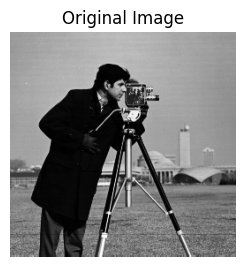

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(x, cmap='gray')
plt.axis('off')



Visualize the Reconstructed image.

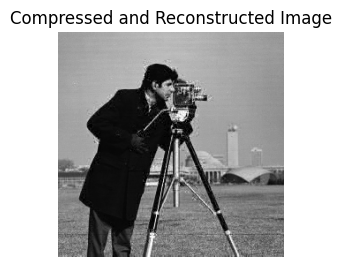

In [ ]:
plt.subplot(1, 2, 2)
plt.title('Compressed and Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

size of the original image and compressed image.
Image size in bytes.

In [ ]:
import os

original_size = os.path.getsize("Original_Image.jpg")
compressed_size = os.path.getsize("reconstructed_image.jpg")

print(f"Original Image Size: {original_size} bytes")
print(f"Compressed Image Size: {compressed_size} bytes")

Original Image Size: 17971 bytes
Compressed Image Size: 9644 bytes


This ratio is used as a quality measurement between
**the original and a compressed image.**

The higher the peak signal-to-noise ratio (PSNR), **the better the quality of the compressed, or reconstructed image.**

In [ ]:
def calculate_psnr(original_image, reconstructed_image):
    # Convert images to float32.
    original_image = original_image.astype(np.float32)
    reconstructed_image = reconstructed_image.astype(np.float32)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original_image - reconstructed_image) ** 2)

    # If MSE is zero, the images are identical
    if mse == 0:
        return float('inf')  # Return infinity for perfect reconstruction

    # Compute PSNR
    max_pixel_value = 255.0
    psnr = 10 * np.log10(max_pixel_value**2 / mse)
    return psnr

# Load the original and reconstructed images (example usage)
# Check if the images are loaded correctly
original = cv2.imread('/content/Original_Image.jpg', cv2.IMREAD_GRAYSCALE)
reconstructed = cv2.imread('/content/reconstructed_image.jpg', cv2.IMREAD_GRAYSCALE)


if original is None:
    print("Error: Could not load original image. Please check the file path.")
    original = np.zeros((256, 256), dtype=np.uint8)

if reconstructed is None:
    print("Error: Could not load reconstructed image. Please check the file path.")
    reconstructed = np.zeros((256, 256), dtype=np.uint8)

# Calculate PSNR
psnr_value = calculate_psnr(original, reconstructed)
print(f"peak signal-to-noise ratio(PSNR) value is: {psnr_value:.2f} decibels(dB)")

peak signal-to-noise ratio(PSNR) value is: 29.03 decibels(dB)


In [ ]:
def calculate_compression_rate(original_size, compressed_size):
    if compressed_size == 0:
        return float('inf')
    #compression = original_size/compressed_size
    compression_rate = (1-(compressed_size/original_size))*100
    return compression_rate

#original_size = os.path.getsize("Original_Image.jpg")  # Original image size in bytes
#compressed_size = os.path.getsize("reconstructed_image.jpg")  # Compressed image size in bytes

compression_rate = calculate_compression_rate(original_size, compressed_size)
print(f"Compression Rate: {compression_rate}")


Compression Rate: 46.335763174002565


In [ ]:
#compression Ratio
def compression_rate(original_size, compressed_size):
    compression_ratio =  original_size/ compressed_size
    return compression_ratio

ratio=compression_rate(original_size, compressed_size)
print(f"Compression Ratio: {ratio}")

Compression Ratio: 1.8634384072998755
